In [1]:
import sys
# import numpy as np
# import matplotlib.pyplot as plt
import pandas as pd
# import lightkurve as lk
# from scipy.optimize import curve_fit

# from astropy.convolution import Gaussian1DKernel
# from astropy.convolution import convolve
sys.path.insert(0, "../")

from michael import janet

Hi there. Welcome to the good place.


In [2]:
uni = pd.read_csv("/Users/oliver hall/Research/unicorn/data/unicorn.csv", index_col=0)

Index 258 is a good tester. Clear rotational signal, ambiguous peak mode.

In [13]:
uni.loc[258]

source_id                1.923544e+18
ra                       3.512744e+02
ra_error                 4.587520e-02
dec                      4.101105e+01
dec_error                3.944148e-02
parallax                 1.910751e+01
parallax_error           7.092294e-02
pmra                     1.707999e+02
pmra_error               8.459705e-02
pmdec                    4.894278e+01
pmdec_error              8.278920e-02
phot_g_mean_mag          1.488943e+01
bp_rp                    3.049434e+00
radial_velocity                   NaN
radial_velocity_error             NaN
ruwe                     1.183059e+00
u                       -1.352553e+01
v                        4.760564e+01
w                       -1.702239e+01
U                       -4.199259e+01
V                       -1.303992e+01
W                       -3.101906e+00
l                        1.058607e+02
b                       -1.898105e+01
pmraK                    4.237452e+01
pmdecK                   1.214244e+01
pmlK        

In [14]:
# j = janet.boot(uni, index=258)
j = janet(gaiaid = "test", ra= 3.513e2, dec = 4.101e1, 
         output_path = '/Users/oliver hall/Research/unicorn/data/custom')

Already have data downloaded for Gaia ID 1923544057484996224.
If you want to check for new data, run `janet.update()`.
### Running Simple Astropy Lomb-Scargle on Sector 16 on star 1923544057484996224 ###
### Completed Simple Astropy Lomb-Scargle for Sector 16 on star 1923544057484996224 ###
### Saved results ###
### Running Simple Astropy Lomb-Scargle on Sector 17 on star 1923544057484996224 ###
### Completed Simple Astropy Lomb-Scargle for Sector 17 on star 1923544057484996224 ###
### Saved results ###
### Running Simple Astropy Lomb-Scargle on Sector all on star 1923544057484996224 ###
### Completed Simple Astropy Lomb-Scargle for Sector all on star 1923544057484996224 ###
### Saved results ###
### Running Wavelet Estimation on star 1923544057484996224 ###


/Users/Anaconda/anaconda3/lib/python3.8/site-packages/jazzhands/wavelets.py:488: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm



### Completed Wavelet Estimation on star 1923544057484996224 ###
### Saved results ###
### Running ACF Estimation on star 1923544057484996224 ###
### Completed ACF Estimation on star 1923544057484996224 ###
### Saved results ###
### Saved results ###
### Saved results ###
### Saved results ###
### Saved results ###

------ Decoding Overall Period Flag 1 ------
1: Best rotation is from the Simple Lomb Scargle (SLS) method.

No other flags raised. 

### Saved results ###


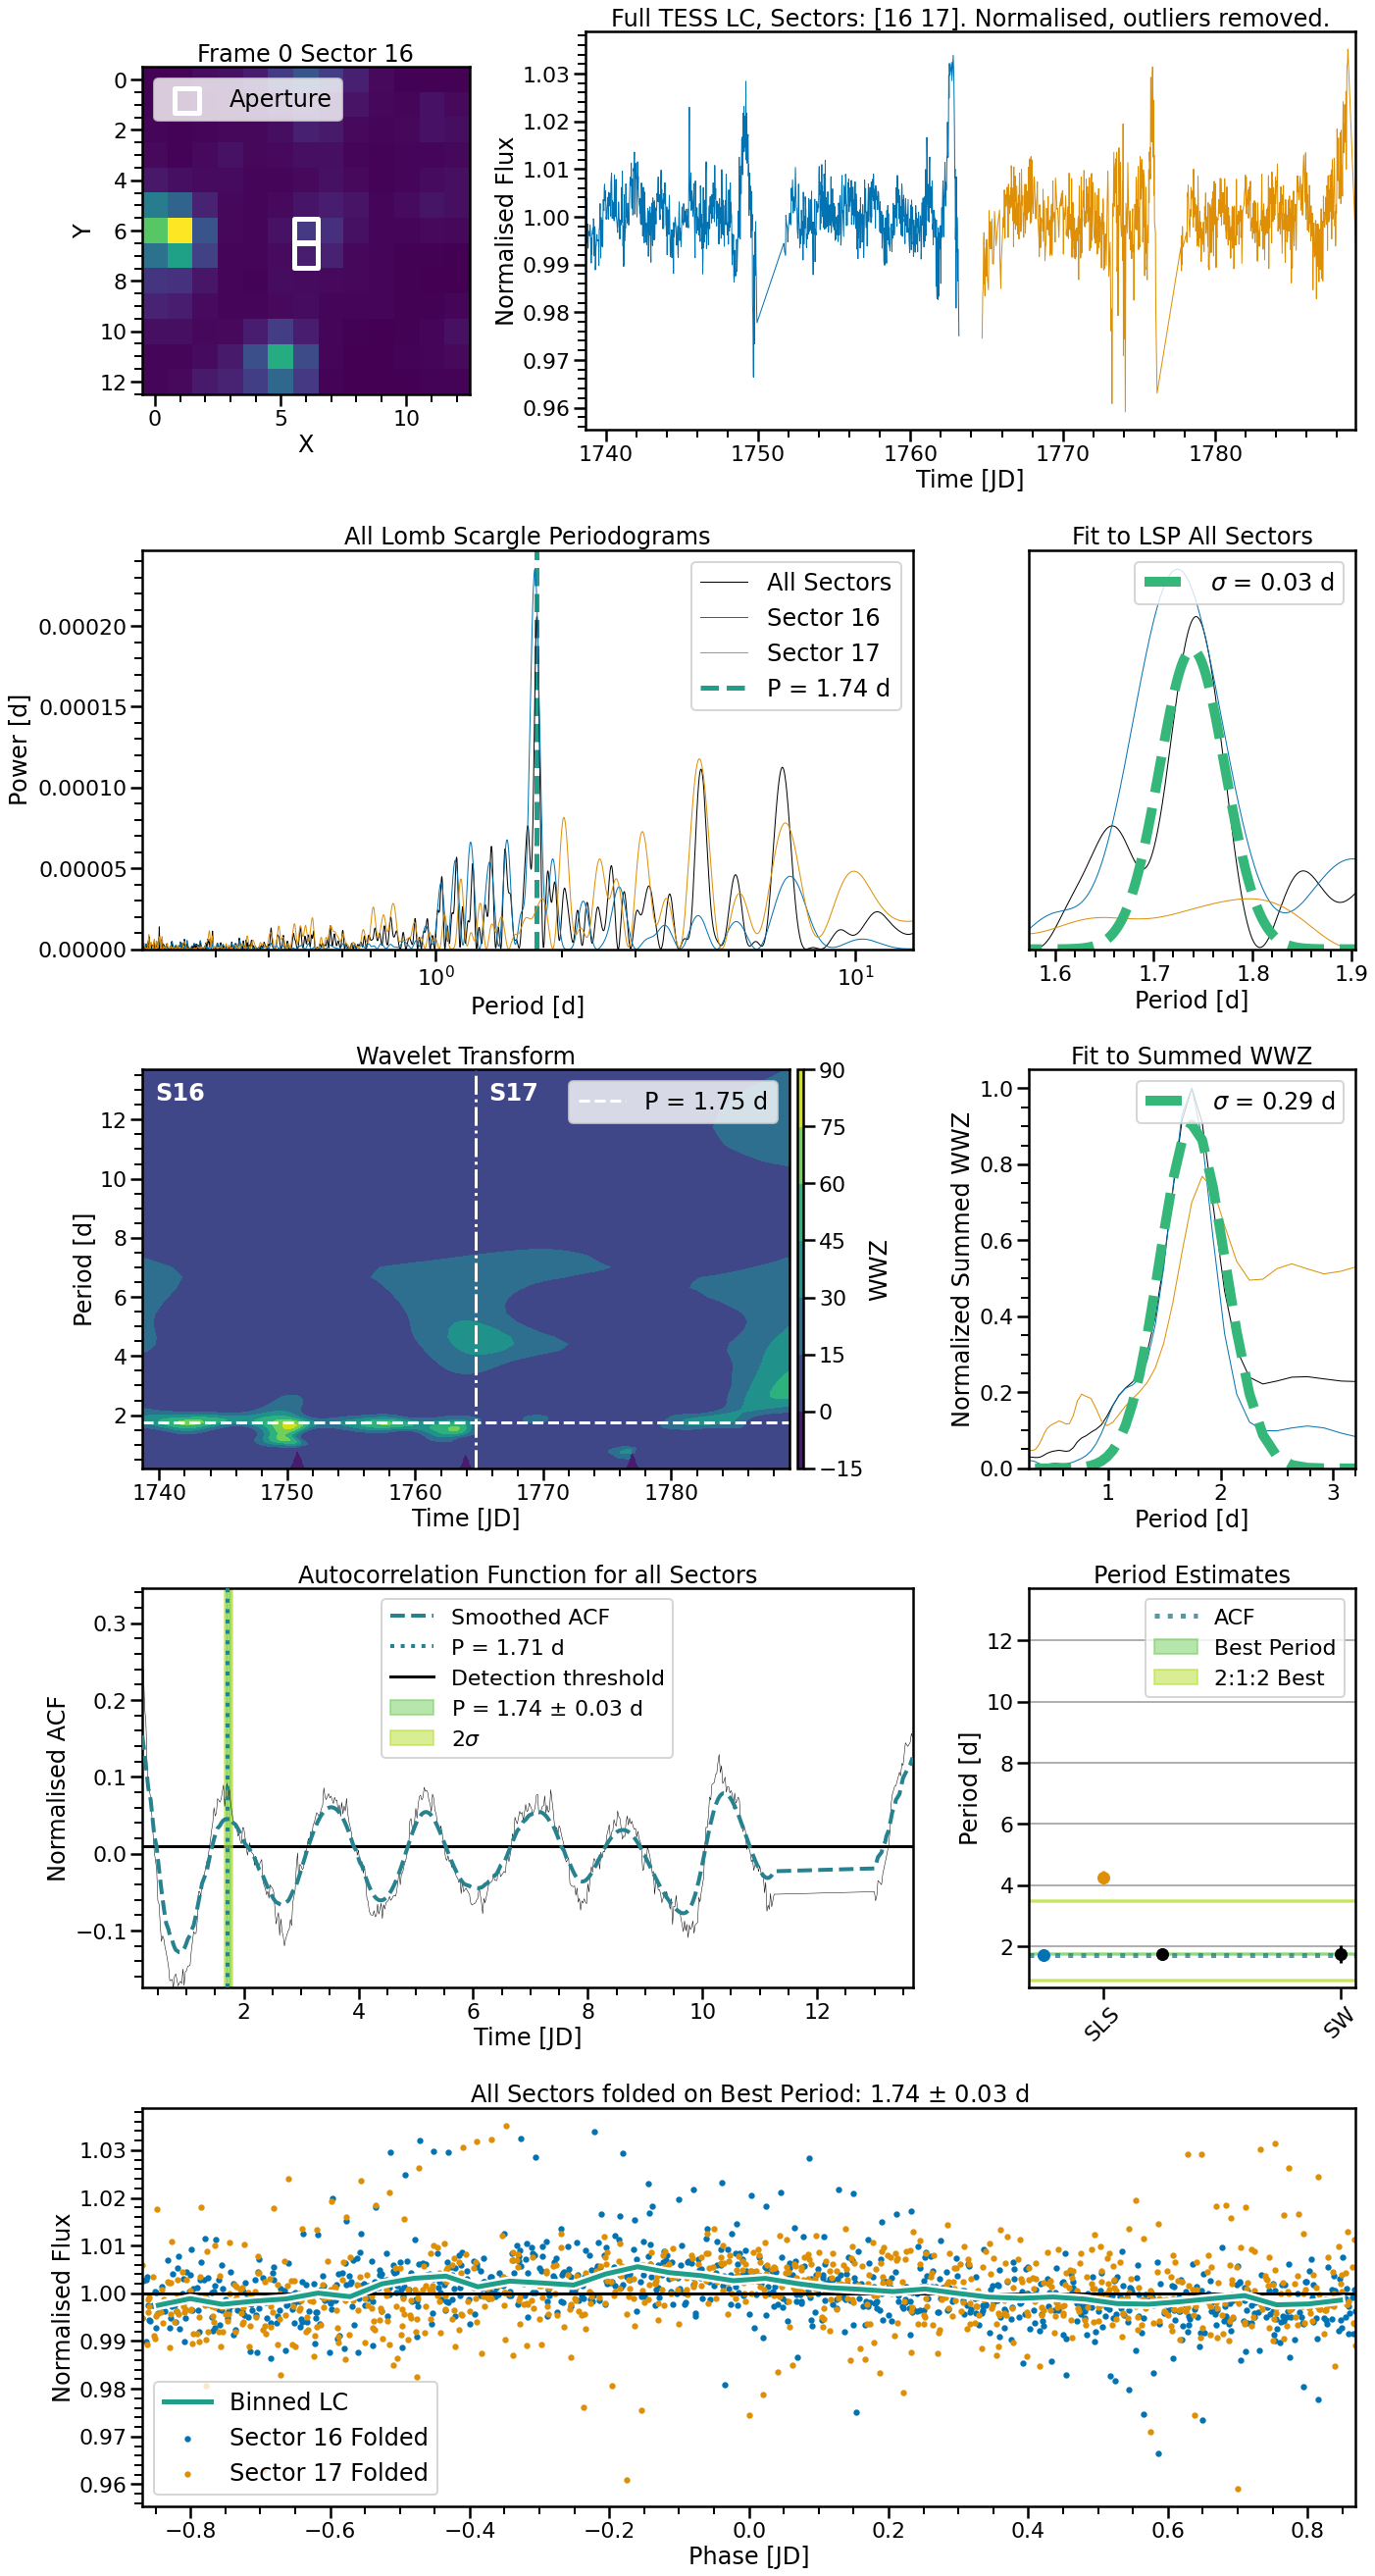

In [4]:
j.run()

In [5]:
import numpy as np
import lightkurve as lk
import matplotlib.pyplot as plt

import pymc3 as pm

In [6]:
acfsmoo = j.void['acfsmoo']
wt = j.void['wt']
nus = wt.nus
wwz = j.void['wwz']

In [7]:
acfsmoolc = lk.LightCurve(time = j.void['acflc'].time.value, flux = acfsmoo)

In [8]:
Model = pm.Model()
P = acfsmoolc.time.value
F = acfsmoolc.flux.value

with Model:
    A0 = pm.Uniform('A0', 0., 1., testval=0.05)
    A1 = pm.Uniform('A1', 0., 10., testval=0.5)
    yy = pm.Deterministic('yy', (1-A0)*np.exp(-P/A1) + A0)
    y = pm.Normal('like', mu=yy, sigma = np.std(F),
                 observed=F)

In [9]:
with Model:
    trace = pm.sample()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [A1, A0]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 21 seconds.
There were 14 divergences after tuning. Increase `target_accept` or reparameterize.
There were 5 divergences after tuning. Increase `target_accept` or reparameterize.
There were 6 divergences after tuning. Increase `target_accept` or reparameterize.
There were 3 divergences after tuning. Increase `target_accept` or reparameterize.


In [10]:
yy = np.median(trace['yy'], axis=0)
normacf = acfsmoolc - yy

In [11]:
binned = normacf.bin()